##  Introduction to Artificial Neural Networks with Keras 

#### This notebook is modified from chapter 10 of the book Handson Machine Learning with scikit-learn and TensorFlow


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron 

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [1]:
import tensorflow as tf
from tensorflow import keras

In [4]:
tf.__version__

'2.7.0'

In [5]:
keras.__version__

'2.7.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [7]:
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Each pixel intensity is represented as a byte (0 to 255):

In [8]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)
(55000,) (5000,) (10000,)


You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

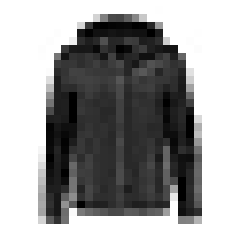

In [10]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [11]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [13]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [14]:
X_valid.shape

(5000, 28, 28)

In [15]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

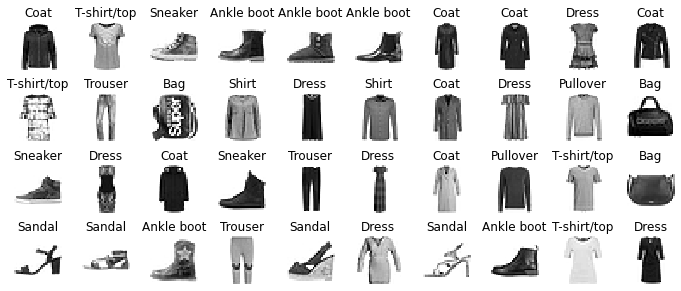

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
 
plt.show()

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [20]:
model.layers

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


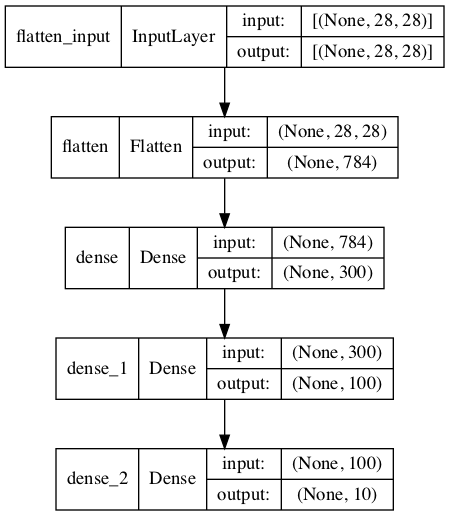

In [22]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [23]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [24]:
model.get_layer(hidden1.name) is hidden1

True

In [25]:
weights, biases = hidden1.get_weights()

In [26]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [27]:
weights.shape

(784, 300)

In [28]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [29]:
biases.shape

(300,)

That's it, we've constructed out model. To compile it we use `model.compile`. We will use the Adam optimizer, which automatically sets a different learning schedule for each weight. For more information about Adam, see [Jason Brownlee's excelent post](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) or [the original paper of Kingma and Ba](https://arxiv.org/abs/1412.6980). 

To train the model, use

`model.fit(X_train, Y_train,
          batch_size=, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))`

* `X_train` is the whole set of training data.
* `Y_train` is the whole set of label data.
* `batch_size` is size of each training minibatch. Remember that 1 is __stochastic gradient decent__ while 60000 (the size of the whole data set) would be __gradient decent__. 
* `verbose` sets how much information to output during fitting. 0 = silent, 1 = progress bar, 2 = one line per epoch.
* `validation_data=()` specifies data to validate on after each training epoch. 

We will save the output of the training in a variable called `history` for later viewing. 

https://keras.io/models/model/

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [31]:
# training the model and saving metrics in history
# minibatch
history = model.fit(X_train, y_train,
          batch_size=128, epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid))

Epoch 1/30
430/430 [==============================] - 2s 4ms/step - loss: 1.1025 - accuracy: 0.6712 - val_loss: 0.7029 - val_accuracy: 0.7768
Epoch 2/30
430/430 [==============================] - 2s 4ms/step - loss: 0.6412 - accuracy: 0.7880 - val_loss: 0.5705 - val_accuracy: 0.8194
Epoch 3/30
430/430 [==============================] - 2s 4ms/step - loss: 0.5552 - accuracy: 0.8144 - val_loss: 0.5358 - val_accuracy: 0.8188
Epoch 4/30
430/430 [==============================] - 2s 4ms/step - loss: 0.5121 - accuracy: 0.8273 - val_loss: 0.4947 - val_accuracy: 0.8346
Epoch 5/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4871 - accuracy: 0.8337 - val_loss: 0.4614 - val_accuracy: 0.8438
Epoch 6/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4682 - accuracy: 0.8390 - val_loss: 0.4469 - val_accuracy: 0.8522
Epoch 7/30
430/430 [==============================] - 2s 4ms/step - loss: 0.4542 - accuracy: 0.8441 - val_loss: 0.4365 - val_accuracy: 0.8558
Epoch 

In [32]:
#stochastic gradient decent
historysgd = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3572 - accuracy: 0.8734 - val_loss: 0.3663 - val_accuracy: 0.8700
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.8774 - val_loss: 0.3491 - val_accuracy: 0.8758
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3328 - accuracy: 0.8822 - val_loss: 0.4738 - val_accuracy: 0.8266
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3246 - accuracy: 0.8843 - val_loss: 0.3365 - val_accuracy: 0.8818
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3180 - accuracy: 0.8863 - val_loss: 0.3281 - val_accuracy: 0.8818
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3067 - accuracy: 0.8906 - val_loss: 0.3357 - val_accuracy: 0.8820
Epoch 7/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3007 - accuracy: 0.8938 - val_loss: 0.3283 - val_accuracy:

In [33]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 430}

In [34]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

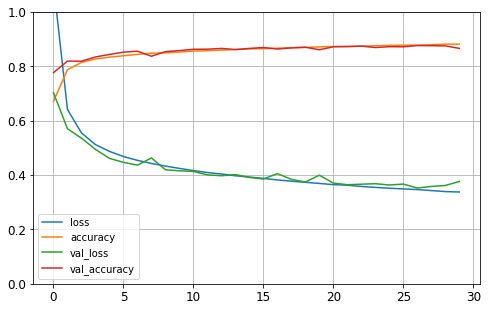

In [36]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
 
plt.show()

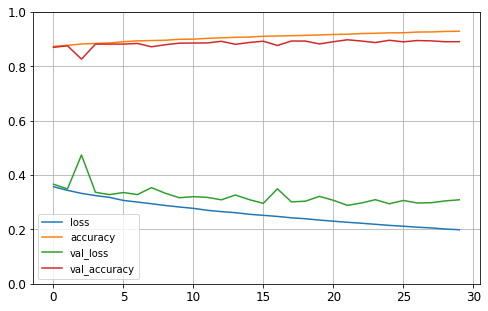

In [37]:
pd.DataFrame(historysgd.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
 
plt.show()

In [38]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3432 - accuracy: 0.8837


[0.3431859314441681, 0.8837000131607056]

In [39]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [40]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [41]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [42]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

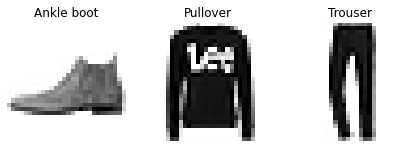

In [43]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
 
plt.show()

### Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [44]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [45]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [48]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.4994 - val_loss: nan - val_accuracy: 0.0914


Text(0, 0.5, 'Loss')

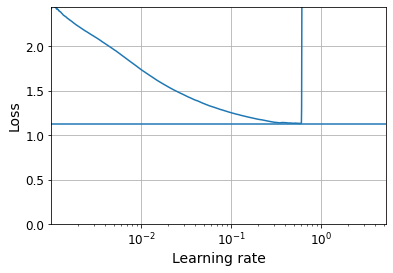

In [49]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 5e-1, so let's try using half of that, at 2e-1, or try at 1e-1

In [50]:
min(expon_lr.losses)

1.1314560174942017

In [51]:
expon_lr.rates[np.argmin(expon_lr.losses)]

0.66101235

##### Let us set learning rate as 0.6

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
#The model needs to be recalled each time.

In [54]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=3e-1),
              metrics=["accuracy"])

/usr/local/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [55]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5712 - accuracy: 0.7844 - val_loss: 0.5462 - val_accuracy: 0.7906
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4083 - accuracy: 0.8482 - val_loss: 0.3512 - val_accuracy: 0.8706
Epoch 3/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3640 - accuracy: 0.8651 - val_loss: 0.5123 - val_accuracy: 0.8084
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3405 - accuracy: 0.8730 - val_loss: 0.3364 - val_accuracy: 0.8714
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3241 - accuracy: 0.8797 - val_loss: 0.3204 - val_accuracy: 0.8828
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3069 - accuracy: 0.8849 - val_loss: 0.3399 - val_accuracy: 0.8774
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2949 - accuracy: 0.8897 - val_loss: 0.3707 - val_accuracy:

## Early Stopping

In [56]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, callbacks

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
#The model needs to be recalled each time.

In [59]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [60]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [61]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5414 - accuracy: 0.7981 - val_loss: 0.5483 - val_accuracy: 0.7924
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3934 - accuracy: 0.8525 - val_loss: 0.3805 - val_accuracy: 0.8560
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3519 - accuracy: 0.8701 - val_loss: 0.4975 - val_accuracy: 0.8178
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3277 - accuracy: 0.8766 - val_loss: 0.3335 - val_accuracy: 0.8732
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3109 - accuracy: 0.8837 - val_loss: 0.3160 - val_accuracy: 0.8878
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2924 - accuracy: 0.8905 - val_loss: 0.3218 - val_accuracy: 0.8860
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2829 - accuracy: 0.8936 - val_loss: 0.3371 - val_ac

These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the
previous 20 epochs, then stop the training and keep the best model you found.”

In [62]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)
model.evaluate(X_valid, y_valid)
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2233 - accuracy: 0.9150


[0.22327744960784912, 0.9149818420410156]

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [63]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

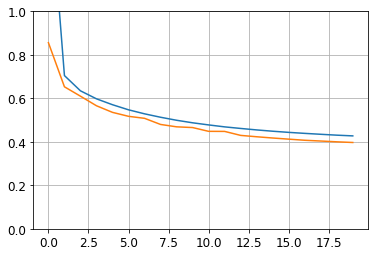

In [66]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [67]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

# Saving and Restoring

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

/usr/local/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [71]:
model.save("my_keras_model.h5")

In [72]:
model5 = keras.models.load_model("my_keras_model.h5")

In [73]:
model5.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")

In [75]:
model.load_weights("my_keras_weights.ckpt")